This is publicly available data from LendingClub.com. Lending Club connects people who need money (borrowers) with people who have money (investors). Hopefully, as an investor you would want to invest in people who showed a profile of having a high probability of paying you back.

## Understanding the data

The data set has 9,500 loans with information on the loan structure, the borrower, and whether the loan was paid back in full. We will get rid of the target column not.fully.paid to meet the unsupervised aspect.

In [1]:
import pandas as pd
loan_data = pd.read_csv("loan_data.csv")
loan_data.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [2]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Preprocessing the data

In [3]:
percent_missing =round(100*(loan_data.isnull().sum())/len(loan_data),2)
percent_missing

credit.policy        0.0
purpose              0.0
int.rate             0.0
installment          0.0
log.annual.inc       0.0
dti                  0.0
fico                 0.0
days.with.cr.line    0.0
revol.bal            0.0
revol.util           0.0
inq.last.6mths       0.0
delinq.2yrs          0.0
pub.rec              0.0
not.fully.paid       0.0
dtype: float64

In [4]:
cleaned_data = loan_data.drop(['purpose', 'not.fully.paid'], axis=1)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   int.rate           9578 non-null   float64
 2   installment        9578 non-null   float64
 3   log.annual.inc     9578 non-null   float64
 4   dti                9578 non-null   float64
 5   fico               9578 non-null   int64  
 6   days.with.cr.line  9578 non-null   float64
 7   revol.bal          9578 non-null   int64  
 8   revol.util         9578 non-null   float64
 9   inq.last.6mths     9578 non-null   int64  
 10  delinq.2yrs        9578 non-null   int64  
 11  pub.rec            9578 non-null   int64  
dtypes: float64(6), int64(6)
memory usage: 898.1 KB


#### Outliers analysis
One of the weaknesses of hierarchical clustering is that it is sensitive to outliers.  The distribution of each variable is given by the boxplot.

<Axes: >

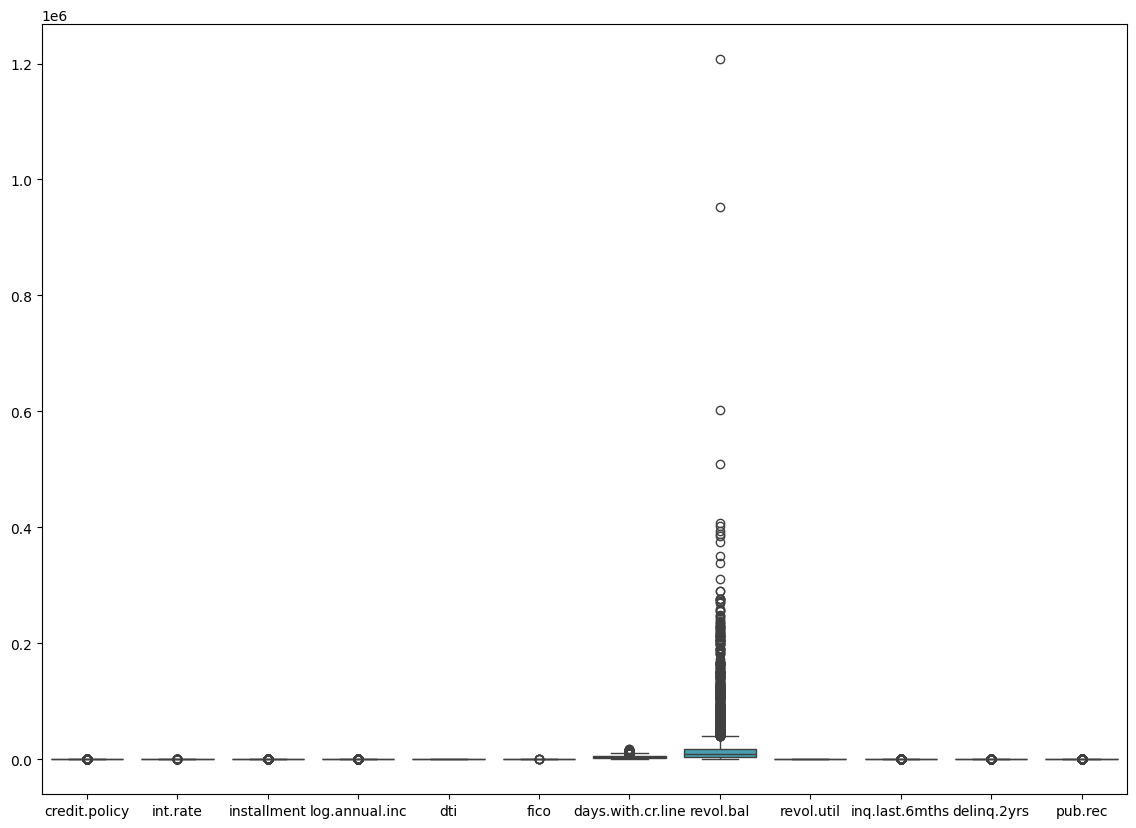

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10)) 
sns.boxplot(data = cleaned_data)

In [14]:
def remove_outliers(data):
   
    df = data.copy()
       
    for col in list(df.columns):
     
          Q1 = df[str(col)].quantile(0.05)
          Q3 = df[str(col)].quantile(0.95)
          IQR = Q3 - Q1
          lower_bound = Q1 - 1.5*IQR
          upper_bound = Q3 + 1.5*IQR
     
          df = df[(df[str(col)] >= lower_bound) & 
    
            (df[str(col)] <= upper_bound)]
       
    return df



In [15]:
without_outliers = remove_outliers(cleaned_data)

<Axes: >

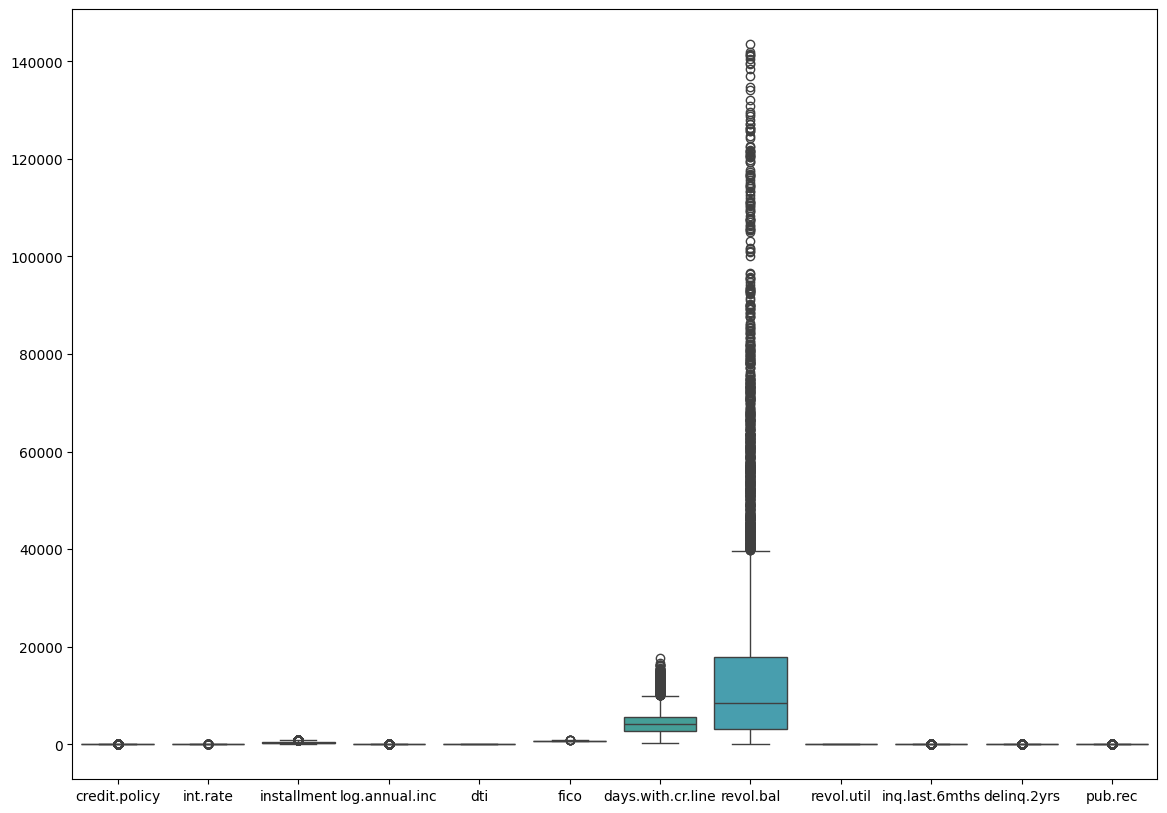

In [16]:
plt.figure(figsize=(14, 10)) 
sns.boxplot(data = without_outliers)

In [17]:
without_outliers.shape

(9319, 12)

The shape of the data is now 9,319 rows and 12 columns. This means that 259 observations were outliers, which have been dropped. 

#### Rescale the data
Since hierarchical clustering uses Euclidean distance, which is very sensitive to dealing with variables with different scales, it’s wise to rescale all the variables before computing the distance. 

In [20]:
from sklearn.preprocessing import StandardScaler

data_scaler = StandardScaler()

scaled_data = data_scaler.fit_transform(without_outliers)

## Applying the hierarchical clustering algorithm 

### <u> scipy.cluster.hierarchy.linkage + dendrogram </u>



In [27]:
from scipy.cluster.hierarchy import linkage, dendrogram

complete_clustering = linkage(scaled_data, method="complete", metric="euclidean")
average_clustering = linkage(scaled_data, method="average", metric="euclidean")
single_clustering = linkage(scaled_data, method="single", metric="euclidean")

The optimal number of clusters can be obtained by identifying the highest vertical line that does not intersect with any other clusters (horizontal line)

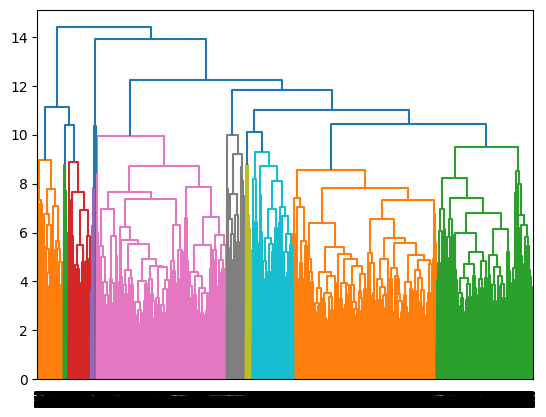

In [24]:
dendrogram(complete_clustering)
plt.show()

For complete linkage, it is the blue line on the right, and it generates three clusters. 

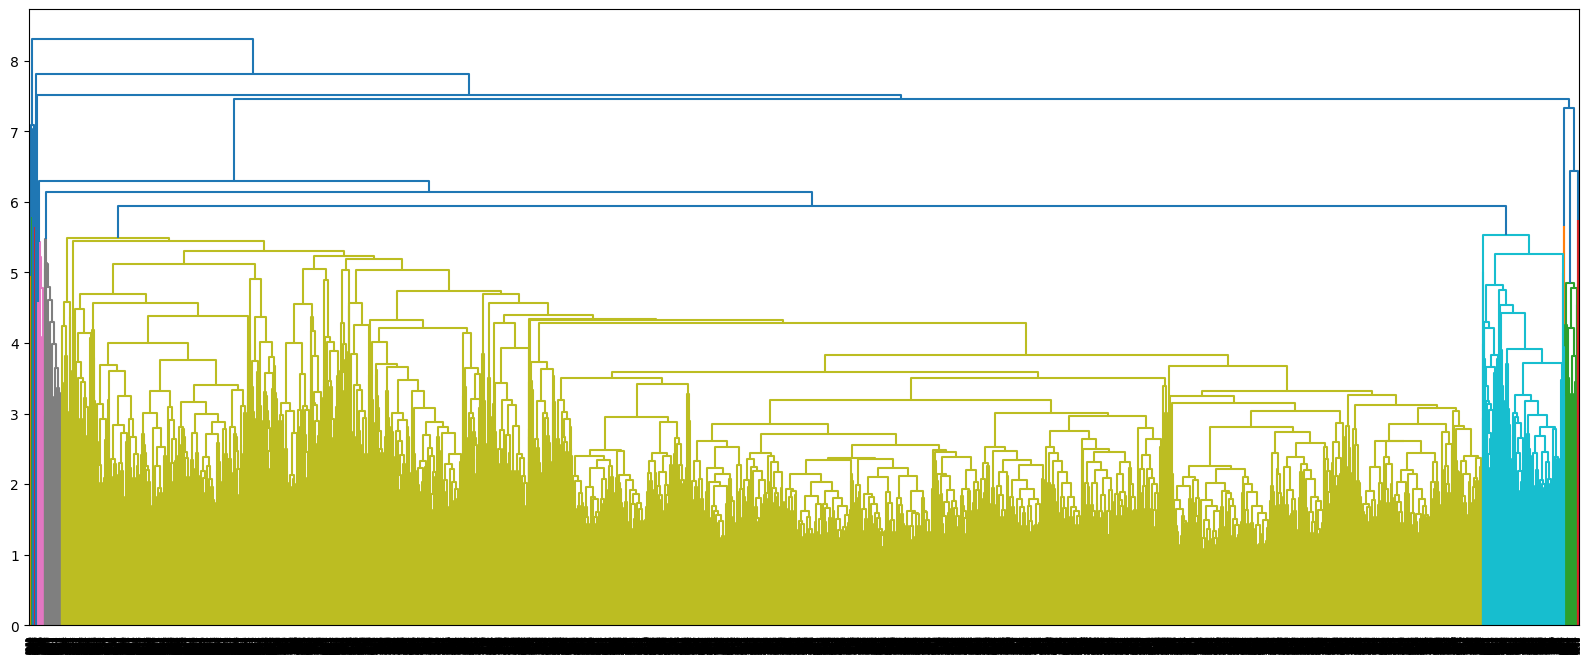

In [38]:
plt.figure(figsize=(20, 8)) 
dendrogram(average_clustering)
plt.show()

For the average linkage, it is the first blue vertical line, and it generates two clusters.

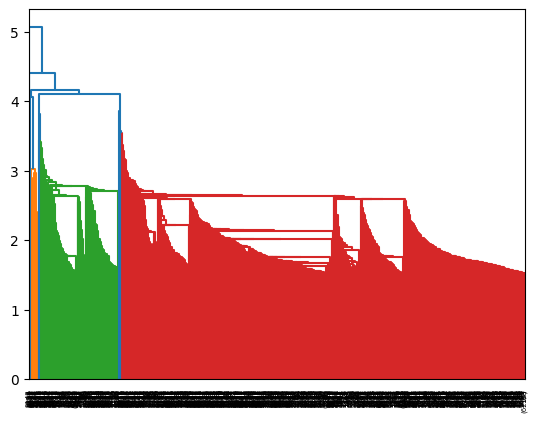

In [32]:
dendrogram(single_clustering,
          truncate_mode='lastp',
          p=999,
          show_leaf_counts=True)
plt.show()

For the single linkage, it is the first vertical line, and it generates only one cluster. 


From the above observations, the average linkage seems to be the one that provides the best clustering, as opposed to the single and complete linkage, which respectively suggests considering one cluster and three clusters. Also, the optimal cluster number of two corresponds to our prior knowledge about the dataset, which is the two types of borrowers.

<Axes: xlabel='Cluster', ylabel='fico'>

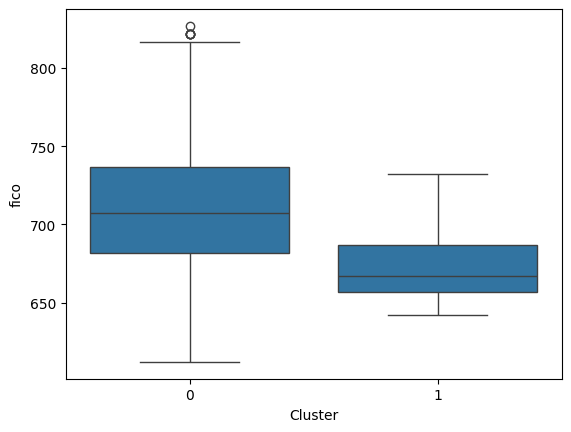

In [37]:
from scipy.cluster.hierarchy import cut_tree

cluster_labels = cut_tree(average_clustering, n_clusters=2).reshape(-1,)
without_outliers['Cluster'] = cluster_labels
sns.boxplot(x='Cluster', y='fico', data=without_outliers)

### INFERENCE

From the above boxplot, we can observe that: 

Borrowers from cluster 0 have the highest credit scores.  
Whereas borrowers from cluster 1 have lower credit scores.